In [1]:
import joblib
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from pathlib import Path
import hist 

import mplhep as hep
hep.style.use(hep.style.ATLAS)
plt.style.use(hep.style.ATLAS)

import sys
core_code_path = '/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/NewWorkflow'
sys.path.append(core_code_path)

from core.Calculate_SF import convert_histdict2unumpy, Construct_unumpy, Map_var_title
from core.utils import HistBins, label_var, label_pt_bin

In [2]:
nominal_preds_path = "/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/NewWorkflow/trained_lightGBM_new/nominal"
nominal_preds_path = Path(nominal_preds_path)

In [3]:
pred_files = sorted(nominal_preds_path.rglob("pythia*_pred.pkl"))

In [4]:
read_columns = ["jet_pt", "jet_nTracks", "GBDT_newScore", "pt_idx", "target", "event_weight"]
def read_pred_file(pred_file: Path, 
                   columns: list=["jet_pt", "jet_nTracks", "GBDT_newScore", "pt_idx", "target", "event_weight"]):
    pred_pd = joblib.load(pred_file)[columns]
    return pred_pd

In [5]:
pred_pd = []
for pred_file in pred_files:
    pred_pd.append(read_pred_file(pred_file))

pred_pd = pd.concat(pred_pd)

In [6]:
pred_pd = pred_pd[pred_pd["target"]!='-']

In [7]:
joblib.dump(pred_pd,"pred_pd.pkl", compress=3)

['pred_pd.pkl']

In [28]:
plot_vars = ["jet_nTracks", "GBDT_newScore"]

In [88]:
def plot_vars_vs_pt_partons(pred_pd:pd.DataFrame, 
                            pt_idxs:list=[0,2,5]):
    colors = ["black", "red", "blue"]
    assert len(colors) == len(pt_idxs)

    splitted_pd = pred_pd.groupby(["target", "pt_idx"])

    for var_idx, var in enumerate(plot_vars):
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))

        for i, pt_idx in enumerate(pt_idxs):
            gluon = splitted_pd.get_group((1, pt_idx))
            quark = splitted_pd.get_group((0, pt_idx))

            bin_contents, bin_edges = np.histogram(gluon[var], bins=HistBins[var], weights=gluon["event_weight"], 
                                                   range=[HistBins[var][0], HistBins[var][-1]])
            bin_contents = bin_contents / np.sum(bin_contents)
            max1 = np.max(bin_contents)
            ax.stairs(bin_contents, bin_edges, 
                      label=rf"Gluon, {label_pt_bin[pt_idx]}< "+r"$p_{T}$"+f" <{label_pt_bin[pt_idx+1]} GeV", 
                      color=colors[i], lw=2, ls='--')
            
            bin_contents, bin_edges = np.histogram(quark[var], bins=HistBins[var], weights=quark["event_weight"], 
                                                   range=[HistBins[var][0], HistBins[var][-1]])
            bin_contents = bin_contents / np.sum(bin_contents)
            max2 = np.max(bin_contents)
            ax.stairs(bin_contents, bin_edges, 
                      label=rf"Quark, {label_pt_bin[pt_idx]}< "+r"$p_{T}$"+f" <{label_pt_bin[pt_idx+1]} GeV", 
                      color=colors[i], lw=2)
            
        ax.set_ylabel("Normalized Entries")
        ax.set_xlabel(Map_var_title[var])

        ax.set_ylim(0, 1.5*np.max([max1, max2]))
        hep.atlas.label()
        plt.legend()
        plt.savefig(f"./plots/Parton_{var}.pdf")
    return fig, ax

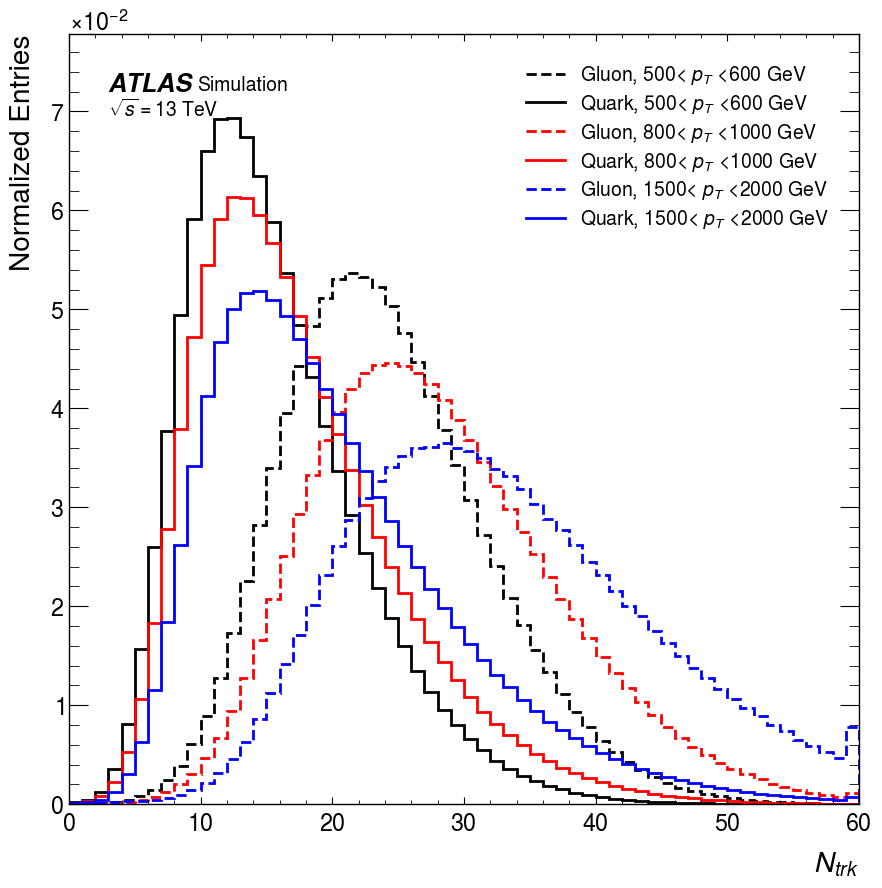

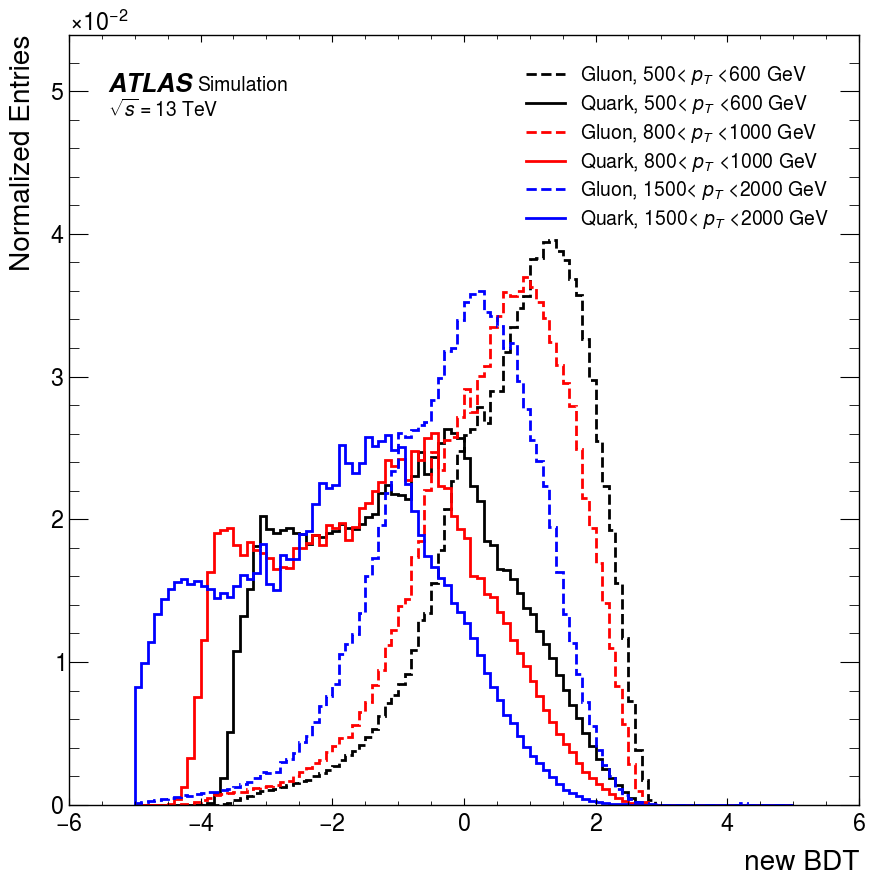

In [89]:
fig, ax = plot_vars_vs_pt_partons(pred_pd)

In [ ]:
def plot_vars_vs_roc_partons(pred_pd:pd.DataFrame, 
                             pt_idxs:list=[0,2,5]):
    colors = ["black", "red", "blue"]
    assert len(colors) == len(pt_idxs)
    pred_pd = pred_pd.loc[pred_pd["target"] != "-"]
    splitted_pd = pred_pd.groupby(["target", "pt_idx"])

    for var_idx, var in enumerate(plot_vars):
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))

        for i, pt_idx in enumerate(pt_idxs):
            gluon = splitted_pd.get_group((1, pt_idx))
            quark = splitted_pd.get_group((0, pt_idx))

            bin_contents, bin_edges = np.histogram(gluon[var], bins=HistBins[var], weights=gluon["event_weight"], 
                                                   range=[HistBins[var][0], HistBins[var][-1]])
            bin_contents = bin_contents / np.sum(bin_contents)
            max1 = np.max(bin_contents)
            ax.stairs(bin_contents, bin_edges, 
                      label=rf"Gluon, {label_pt_bin[pt_idx]}< "+r"$p_{T}$"+f" <{label_pt_bin[pt_idx+1]} GeV", 
                      color=colors[i], lw=2, ls='--')
            
            bin_contents, bin_edges = np.histogram(quark[var], bins=HistBins[var], weights=quark["event_weight"], 
                                                   range=[HistBins[var][0], HistBins[var][-1]])
            bin_contents = bin_contents / np.sum(bin_contents)
            max2 = np.max(bin_contents)
            ax.stairs(bin_contents, bin_edges, 
                      label=rf"Quark, {label_pt_bin[pt_idx]}< "+r"$p_{T}$"+f" <{label_pt_bin[pt_idx+1]} GeV", 
                      color=colors[i], lw=2)
            
        ax.set_ylabel("Normalized Entries")
        ax.set_xlabel(Map_var_title[var])

        ax.set_ylim(0, 1.5*np.max([max1, max2]))
        hep.atlas.label()
        plt.legend()
        plt.savefig(f"./plots/Parton_{var}.pdf")
    return fig, ax

In [ ]:
def plot_ROC(y_decisions, y_tmva, y_ntrk, target, X_weight, features, output_path):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(target, y_decisions, sample_weight = X_weight)
    fpr_tmva, tpr_tmva, thresholds_tmva = roc_curve(target, y_tmva, sample_weight = X_weight)
    fpr_ntrk, tpr_ntrk, thresholds_ntrk =  roc_curve(target, y_ntrk, sample_weight = X_weight)

    roc_auc = auc(fpr, tpr)
    roc_auc_tmva = auc(fpr_tmva, tpr_tmva)
    roc_auc_ntrk = auc(fpr_ntrk, tpr_ntrk)

    fig, ax = plt.subplots()
    plt.plot(1-fpr, tpr, lw=1, label='ROC_NewTraining (area = %0.3f)'%(roc_auc))
    plt.plot(1-fpr_tmva, tpr_tmva, lw=1, label='ROC_oldBDT (area = %0.3f)'%(roc_auc_tmva))
    plt.plot(1-fpr_ntrk, tpr_ntrk, lw=1, label='ROC_Ntrk (area = %0.3f)'%(roc_auc_ntrk))

    plt.plot([0, 1], [1, 0], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC with features:{features}'+r" physical $p_{T}$ weight")
    plt.legend(loc="lower left")
    plt.grid()
    plt.savefig(os.path.join(output_path, "ROC.png"))
    plt.close()

In [8]:
splitted_pd = pred_pd.groupby(["target", "pt_idx"])
test_pd = splitted_pd.get_group((1, 5))

In [9]:
splitted_pd.groups.keys()

dict_keys([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5)])